In [1]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

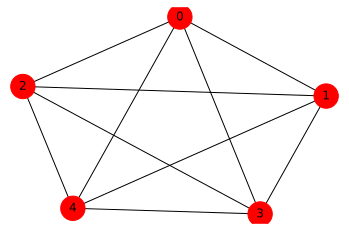

In [59]:
# Generating a complete graph with 5 nodes
n = 5
G = nx.complete_graph(n)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=False)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [60]:
# Create the quantum circuit to implement the QAOA
def evolve_cost(c, angle, G):
    for edge in G.edges():
        i = edge[0]
        j = edge[1]
        c.cx(i,j)
        c.rz(-2*angle, j)
        c.cx(i,j)
    
def evolve_driver(c, angle):
    c.rx(2*angle, c.qubits)
    
    
def gen_qaoa_circ(P, gamma, beta, G):
    """
    P (int) : number of layers to apply
    gamma (list[float]) : list with length p, contains angle parameters for cost Hamiltonian
    beta (list[float]) : list with length p, contains angle parameters for driver Hamiltonian
    G (graph) : NetworkX graph representing the MAXCUT problem instance
    """
    # create the quantum and classical registers
    n = len(G.nodes()) # get the number of vertices (qubits)
    circ = QuantumCircuit(n)
    
    # apply the initial layer of Hadamards
    circ.h(range(n))
    
    # iteratively apply the cost and driver unitaries p times
    for p in range(P):
        circ.barrier()
        evolve_cost(circ, gamma[p], G)
        circ.barrier()
        evolve_driver(circ, beta[p])
        
    # apply measurements to all qubits
    circ.measure_all()
    
    return circ

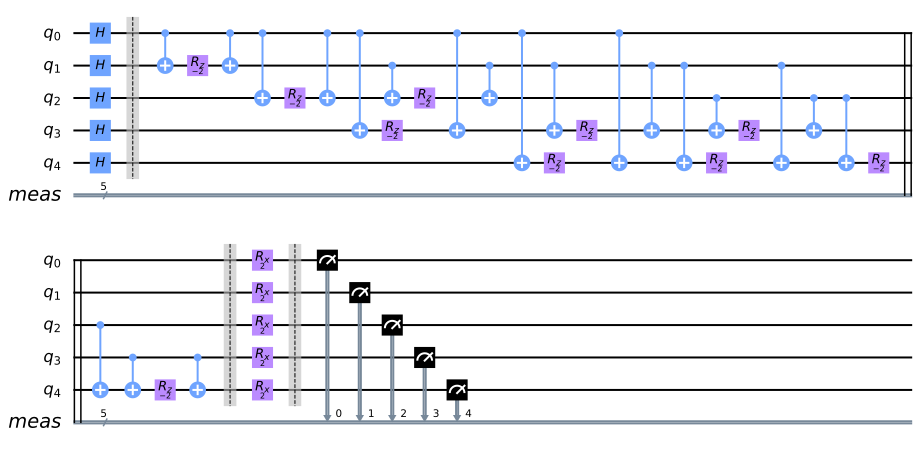

In [61]:
mycirc = gen_qaoa_circ(1, [1], [1], G)
mycirc.draw(output='mpl', scale=0.5)

In [47]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        #w      = G[e1][e2]['weight']
        w = 1
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

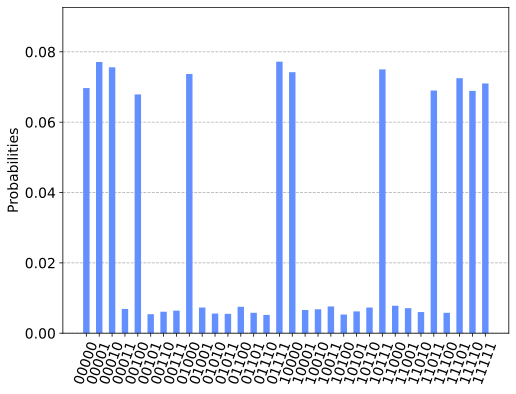

In [48]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(mycirc, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.69 while the true value is M1 = 3.43 

The approximate solution is x* = 10010 with C(x*) = 6 

The cost function is distributed as: 



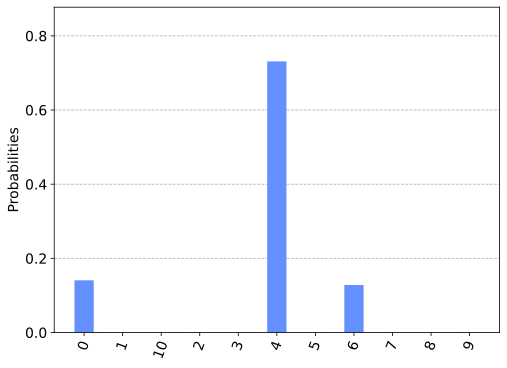

In [49]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
#print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

# Energy Landscape

In [66]:
# Use the circuit generator to estimate the energy landscape
step_size=1
P = 1
backend = Aer.get_backend("qasm_simulator")
shots = 10000

a_gamma = np.arange(0, np.pi, step_size)
a_beta  = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

estC = []
for gamma_list, beta_list in zip(a_gamma, a_beta):
    C_row = []
    for gamma, beta in zip(gamma_list, beta_list):
        qaoa_circ = gen_qaoa_circ(P, [gamma], [beta], G)

        simulate = execute(qaoa_circ, backend=backend, shots=shots)
        QAOA_results = simulate.result()
        
        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()

        avr_C = 0
        hist  = {}

        for k in range(len(G.edges())+1):
            hist[str(k)] = hist.get(str(k),0)

        for sample in list(counts.keys()):
            # use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = cost_function_C(x,G)
    
            # compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample]*tmp_eng
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
                
        M1_sampled   = avr_C/shots
        C_row.append(M1_sampled)
    estC.append(C_row)
estC = np.array(estC)

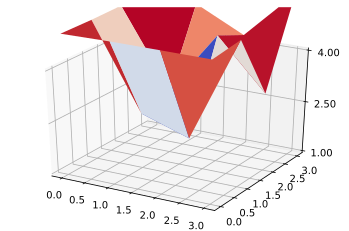

In [68]:
# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, estC, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

(32, 32)


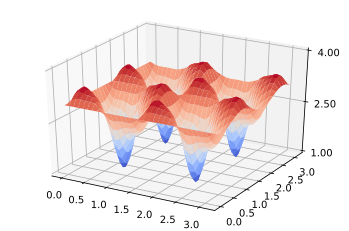


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [58]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)
print(F1.shape)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))